# Preprocessing and Augmentation

To preprocess data we have tried different strategies:
- Remove varibles: for example the first one
- Add new variables: for example adding an average of all the other ones
- Clip signal when exceed defined thresholds
- Normalize sequences and all dataset
- Standardize both on sequences and all dataset
- Use different Scalers such as RobustScaler both on sequences and all dataset

To do data augmentation we have used:
- Functions in tsaug library (TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Dropout)
- Custom functions such as sequence_shifting()

### Import libraries

In [95]:
import tensorflow as tf
import numpy as np
import os
import math
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from skimage.io import imread
from skimage.transform import resize

from tsaug.visualization import plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Dropout


import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [96]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset and compute class weights

In [97]:
data = np.load('training_dataset/x_train.npy')
labels = np.load('training_dataset/y_train.npy')

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                    
                                    )
class_weights = dict(zip(np.unique(labels), class_weights))
class_weights

{0: 5.953431372549019,
 1: 1.6456639566395663,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.968954248366013}

In [98]:
num_vars = 6

columns_y = ['Wish','Another','Comfortably','Money','Breathe','Time','Brain','Echoes','Wearing','Sorrow','Hey','Shine']
columns_x = ['Variable_1','Variable_2','Variable_3','Variable_4','Variable_5','Variable_6']
columns_5vars = ['Variable_2','Variable_3','Variable_4','Variable_5','Variable_6']

sequences_per_label = [34,123,270,381,62,153,313,68,120,777,77,51]

In [99]:
# Function to plot a pandas dataframe
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][:(34*36)])
        axs[i].set_title(col)
    plt.show()

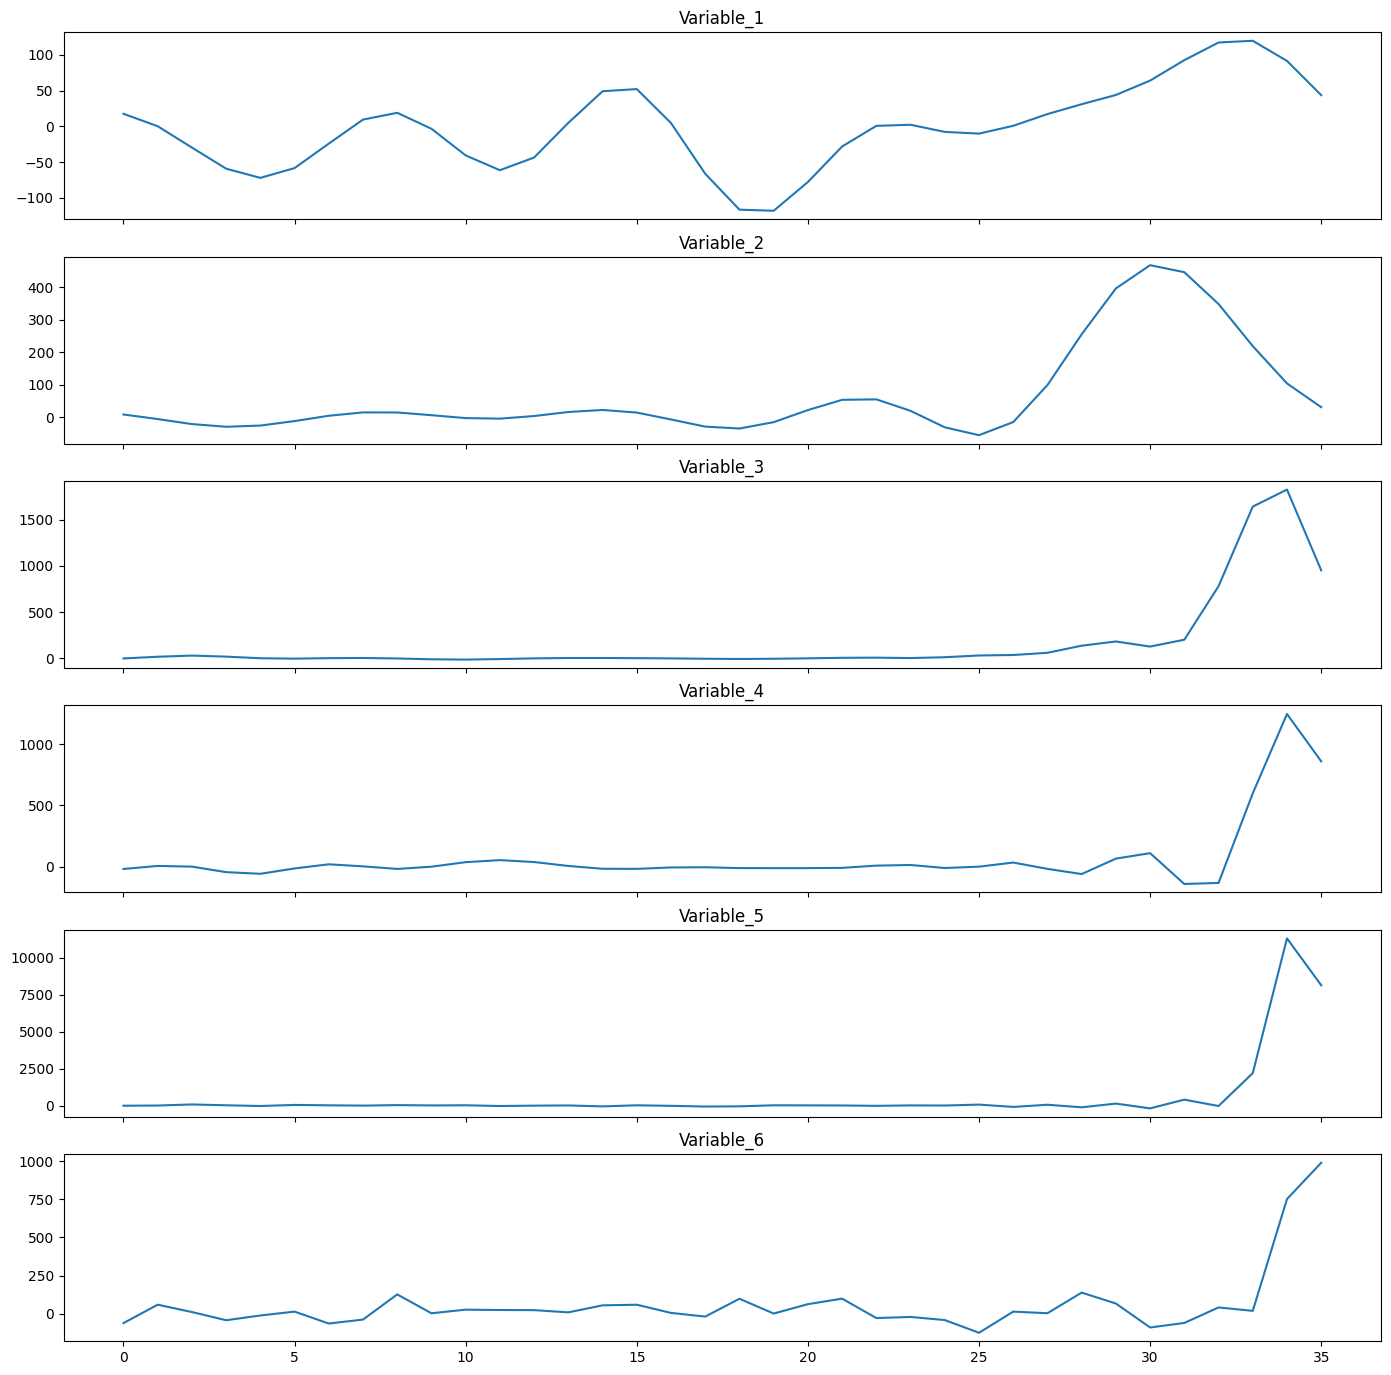

In [100]:
# Here you can see the first sequence of the original dataset
df_original = pd.DataFrame(data[0], columns = columns_x)
inspect_dataframe(df_original, df_original.columns)

## Preprocessing

In [101]:
# Remove Variable_1 from data set
data_5vars = np.zeros((2429,36,5))

for i in range(0,2429):
    for j in range(0,36):
        data_5vars[i,j,0:5] = np.copy(data[i,j,1:6])
data_5vars.shape

(2429, 36, 5)

## Reshape dataset (merge all samples)

In [102]:
# Reshape dataset to apply normalization on the whole dataset
data_reshaped = np.reshape(data, (87444,6))
data_reshaped_5vars = data_5vars.reshape(87444,5)

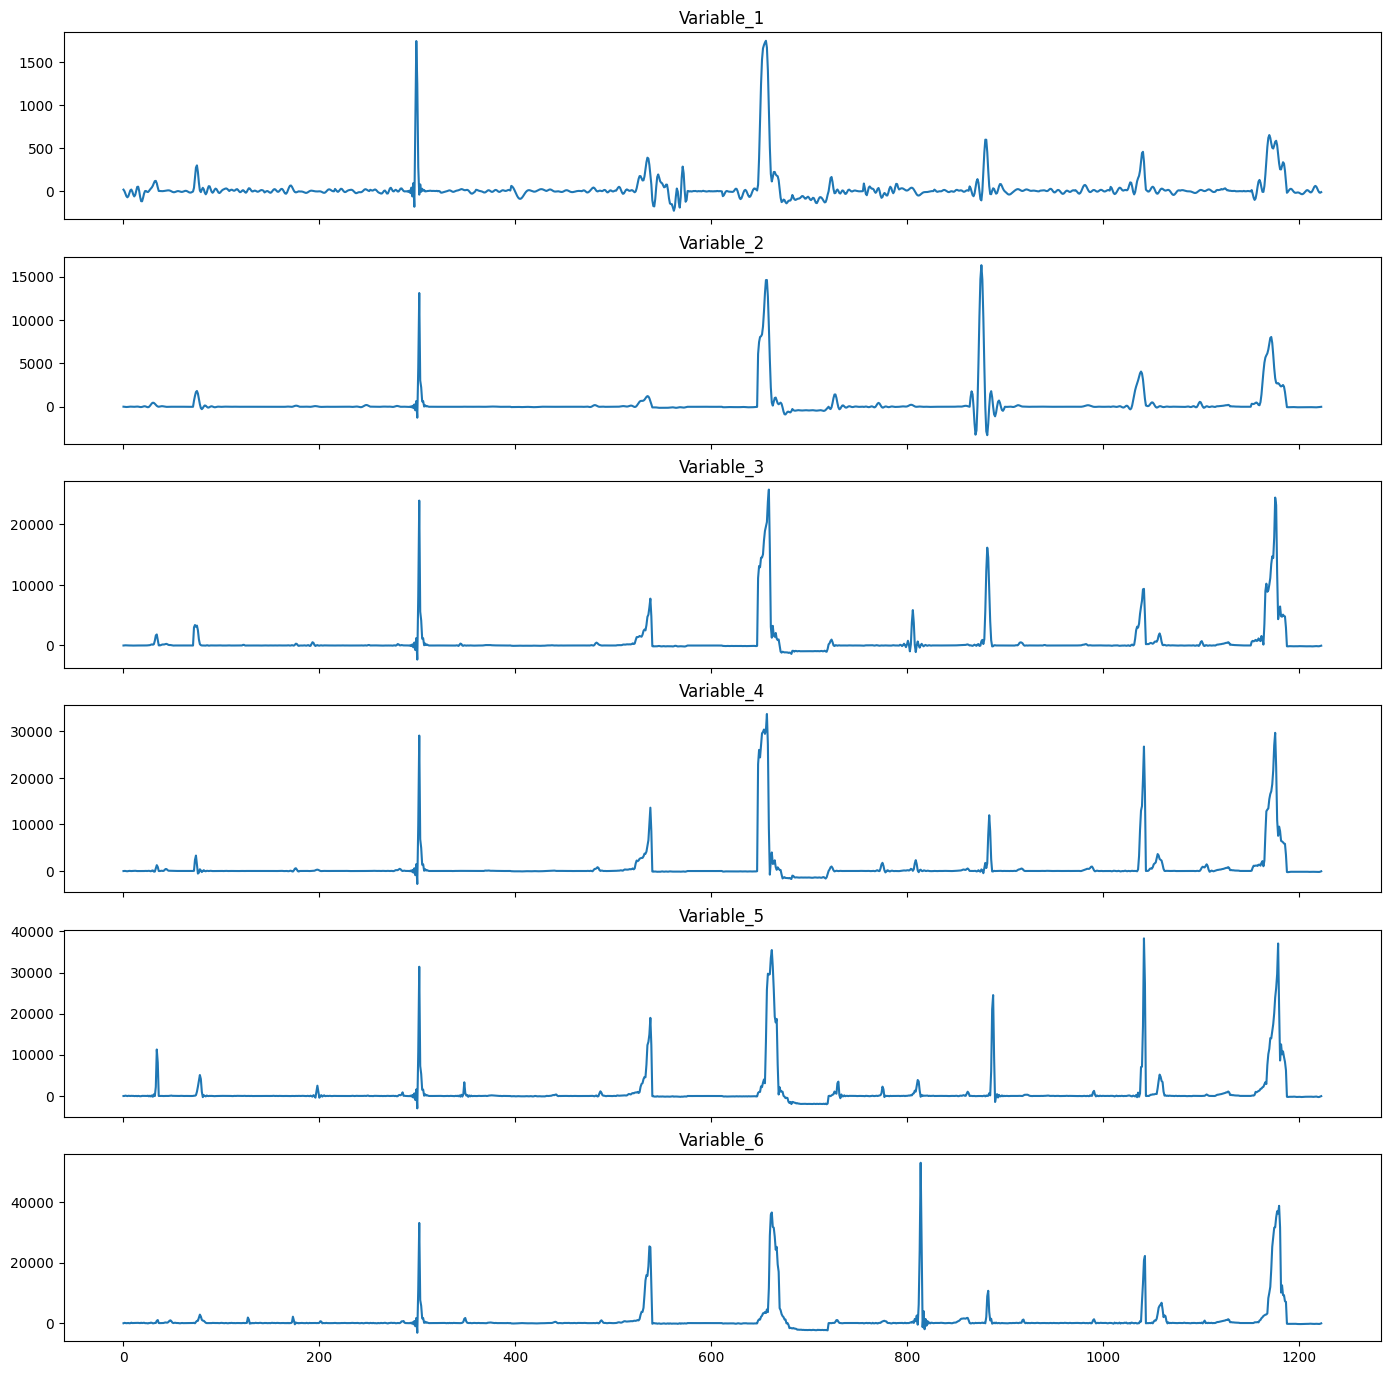

In [103]:
# Here you can see the whole dataset for each variable
df_allDataset = pd.DataFrame(data_reshaped, columns = columns_x)
inspect_dataframe(df_allDataset, df_allDataset.columns)

## Standardization

In [104]:
def manual_std(X, num_vars = 6):
    X_means = np.zeros(num_vars)
    X_stds = np.zeros(num_vars)
    for i in range(0,num_vars):
        X_means[i] = np.mean(X[0:len(X),i])
    for i in range(0,num_vars):
        X_stds[i] = np.std(X[0:len(X),i])

    # Standardize: (data-mean)/std
    X_stand = np.zeros(X.shape)

    for i in range(0,num_vars):
        for j in range (0,len(X)):
            new_data = (X[j,i] - X_means[i])/X_stds[i]
            X_stand[j,i] = new_data

    return X_stand

data_stand = manual_std(data_reshaped)
data_stand.shape

(87444, 6)

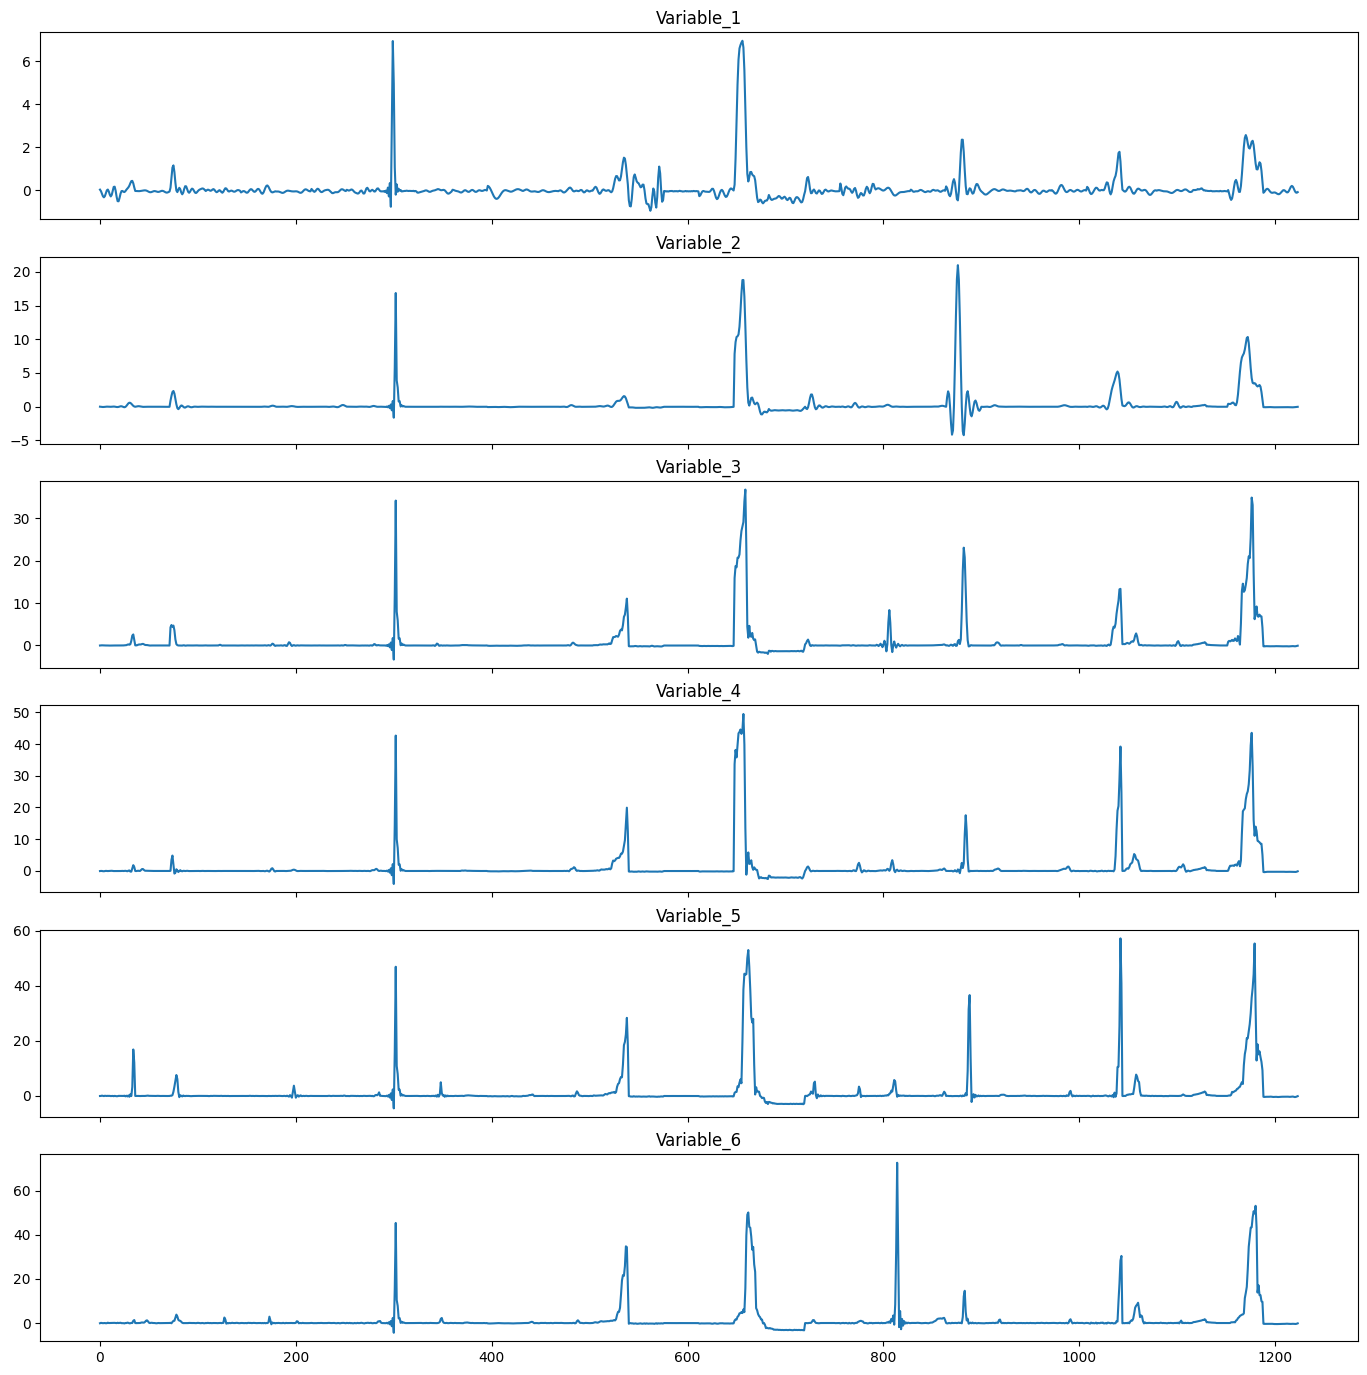

In [105]:
# Here you can see the preprocessing given by the standardize function
df_stand = pd.DataFrame(data_stand, columns = columns_x)
inspect_dataframe(df_stand, df_stand.columns)

## Robust scaler

In [106]:
# Function to apply robust scaler to a dataset
def robust_scale_dataset(X):
    X_scaled = np.copy(X)
    for i in range(num_vars):
        toScale = np.copy(X_scaled[0:len(X),i])
        toScale = toScale.reshape(len(X),1)
        scaler = RobustScaler()
        scaler = scaler.fit(toScale)
        transformed = scaler.transform(toScale)
        X_scaled[0:len(X),i] = transformed.reshape(len(X),)
    return X_scaled

data_robust = robust_scale_dataset(data_reshaped)
data_robust.shape

(87444, 6)

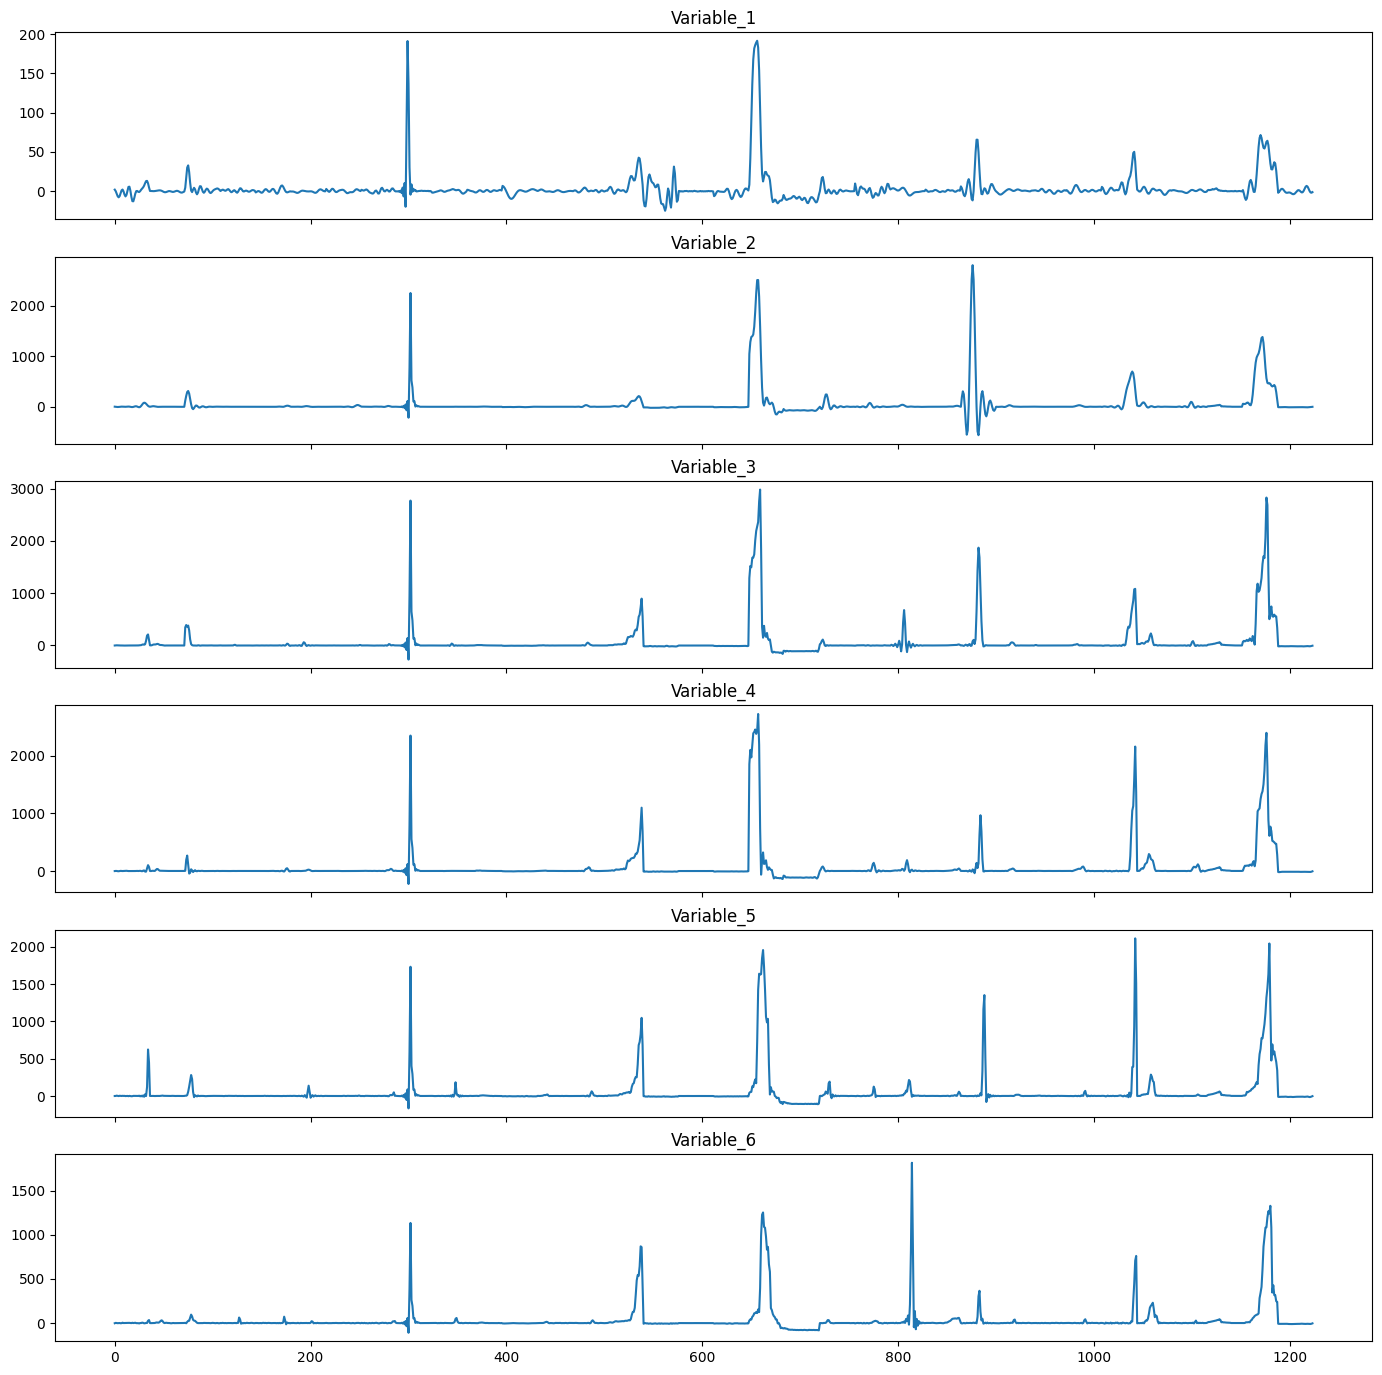

In [107]:
# Here you can see the preprocessing given by the RobustScaler
df_robust = pd.DataFrame(data_robust, columns = columns_x)
inspect_dataframe(df_robust, df_robust.columns)

## Clip signal when esceeding thresholds

In [108]:
max_values = np.zeros(num_vars)
min_values = np.zeros(num_vars)
for i in range(0,num_vars):
    max_values[i] = data_reshaped[0:87444,i].max()
for i in range(0,num_vars):
    min_values[i] = data_reshaped[0:87444,i].min()

means = np.zeros(num_vars)
stds = np.zeros(num_vars)
for i in range(0,num_vars):
    means[i] = np.mean(data_reshaped[0:len(data_reshaped),i])
for i in range(0,num_vars):
    stds[i] = np.std(data_reshaped[0:len(data_reshaped),i])


print(means)
print(stds)
print(max_values)
print(min_values)

[ 9.57137314 17.94285196 26.53100171 32.37399439 33.8747591  31.4817852 ]
[250.30009088 776.63374556 699.08726332 681.84148328 669.44026985
 730.15455478]
[32932. 44394. 37032. 38086. 38490. 53020.]
[ -3420.  -11585.  -10289.   -8009.9  -7326.6  -7584.1]


In [109]:
thresholds = np.zeros(num_vars)
for i in range(0,num_vars):
    thresholds[i] = 6*stds[i]


# Standardize: (data-mean)/std
data_compressed = np.zeros(data_reshaped.shape)

for i in range(0,num_vars):
    for j in range (0,len(data_reshaped)):
        if np.absolute(data_reshaped[j,i]) > thresholds[i]:
            data_compressed[j,i] = thresholds[i]
        else:
            data_compressed[j,i] = data_reshaped[j,i]

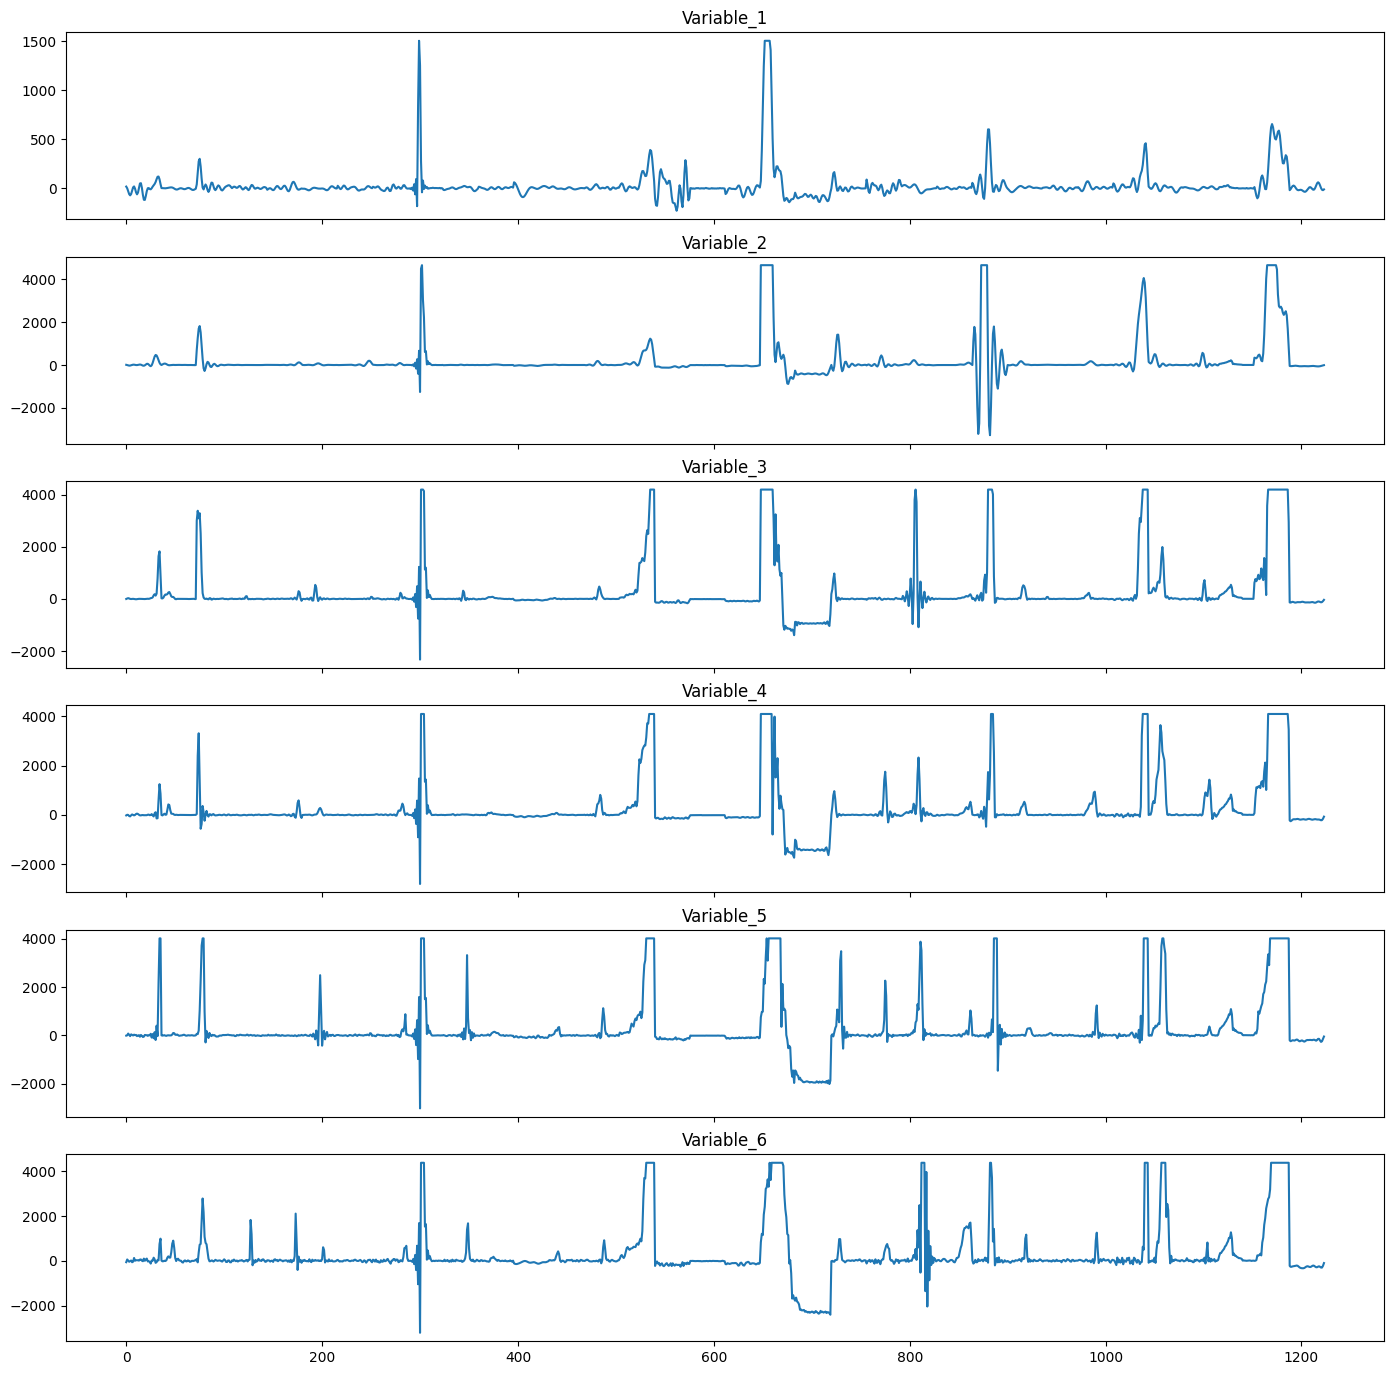

In [110]:
df_compressed = pd.DataFrame(data_compressed, columns=columns_x)
inspect_dataframe(df_compressed, df_compressed.columns)

## Reshape dataset to have sequences with 36 samples

In [111]:
data_compressed_sequenced = data_compressed.reshape(2429,36,num_vars)

In [112]:
X_train, X_valid, y_train, y_valid = train_test_split(data_compressed_sequenced, labels, test_size=0.10, shuffle = True)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2186, 36, 6), (243, 36, 6), (2186,), (243,))

## Augmentation

Using the tsaug library we have inspected different augmentation functions and found out which was the best one to be applied to our model

((1, 36, 6), (2186,))

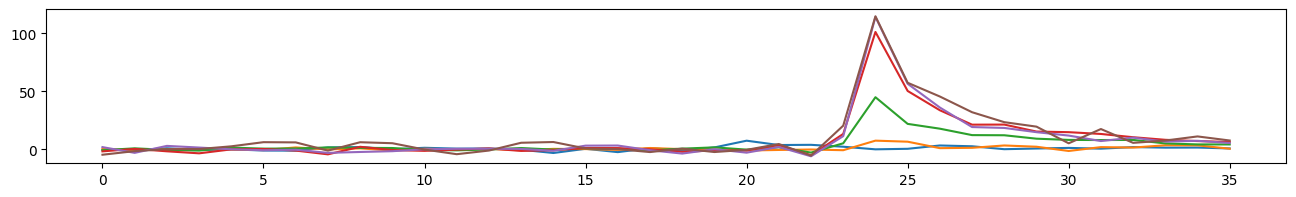

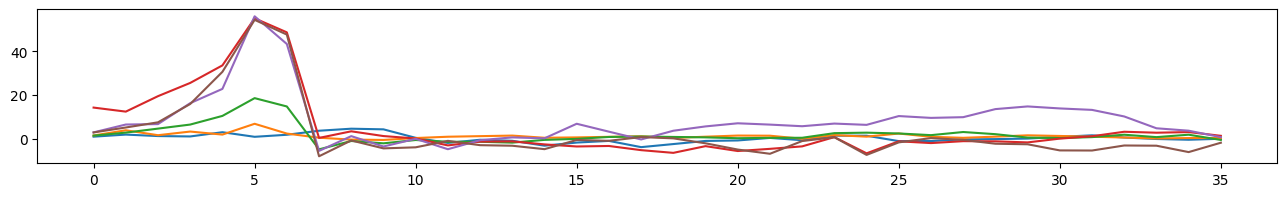

In [113]:
series = np.copy(X_train[0,0:36,0:num_vars])
dummy_batch = np.expand_dims(series, axis=0)
dummy_batch.shape
plot(dummy_batch)

# Inspect possible augmentation provided by tsaug library
my_augmenter = (
    TimeWarp() * 1  # random time warping 1 time
    + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
    + Drift(max_drift=(0.1, 0.2)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 20%
    + Reverse() @ 0.5  # with 50% probability, reverse the sequence
    + AddNoise(scale=(0.01, 0.07)) @ 0.5  # with 50% probability, add random noise up to 1% - 7%
)

X_aug = my_augmenter.augment(dummy_batch)
plot(X_aug)
X_aug.shape, y_train.shape

In [114]:
# Custom function to shift sequences without changing its shape

def shift_sequence(data, num_features = 6):
    sample = np.copy(data)

    # Randomly select a time point from the sample
    time_index = np.random.randint(len(data))
    time_point = sample[time_index]

    # Shift the sample by the randomly selected time point
    shifted_sample = np.roll(sample, time_index, axis=0)

    # Replace a randomly selected feature with the randomly selected time point
    feature_index = np.random.randint(num_features)
    shifted_sample[0, feature_index:] = time_point[feature_index:]

    # Store the augmented sample in the augmented data array
    aug_data = np.copy(shifted_sample)
    return aug_data

In [115]:
def apply_aug(elem):
    elem = shift_sequence(elem)
    elem = my_augmenter.augment(elem)
    return elem

In [116]:
y_train = tfk.utils.to_categorical(y_train)
y_valid = tfk.utils.to_categorical(y_valid)

input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

print(input_shape)
print(classes)

(36, 6)
12


In [117]:
# AugSequencesGenerator is a keras Sequence class that automatically generate batches with defined length

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class AugSequencesGenerator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        # For each elem in the batch augmentation is applied
        return np.array([apply_aug(elem) for elem in batch_x]), np.array(batch_y)

# Instatiate a generator
generator = AugSequencesGenerator(x_set = X_train, y_set = y_train, batch_size=128)

# Model

In [118]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [119]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

### Train

In [120]:
# Utility function to create folders and callbacks for training
def create_callbacks() :
    callbacks = []

    # Early Stopping -----------------------------------------------------
    es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)
    
    # Checkpointer
    checkpointer = ModelCheckpoint(filepath='./checkpoint/BiLSTM.h5', verbose=1, 
                                    save_best_only=True, monitor = "val_accuracy", mode = "auto",)
    callbacks.append(checkpointer)
    
    # Learning Rate Scheduler --------------------------------------------
    LRS_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    callbacks.append(LRS_callback)
    
    return callbacks

In [121]:
# Train the model
history = model.fit(
    x = generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_valid, y_valid),
    class_weight = class_weights,
    callbacks = create_callbacks()
).history

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 2.3356 - accuracy: 0.1148
Epoch 1: val_accuracy improved from -inf to 0.27984, saving model to ./checkpoint\BiLSTM.h5
18/18 [==============================] - 38s 1s/step - loss: 2.3356 - accuracy: 0.1148 - val_loss: 2.0960 - val_accuracy: 0.2798 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 1.9599 - accuracy: 0.2260
Epoch 2: val_accuracy improved from 0.27984 to 0.40329, saving model to ./checkpoint\BiLSTM.h5
18/18 [==============================] - 23s 1s/step - loss: 1.9599 - accuracy: 0.2260 - val_loss: 1.6777 - val_accuracy: 0.4033 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 1.7802 - accuracy: 0.2306
Epoch 3: val_accuracy did not improve from 0.40329
18/18 [==============================] - 25s 1s/step - loss: 1.7802 - accuracy: 0.2306 - val_loss: 1.6210 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 4/200
18/18 [==============================] 

KeyboardInterrupt: 

### Plots

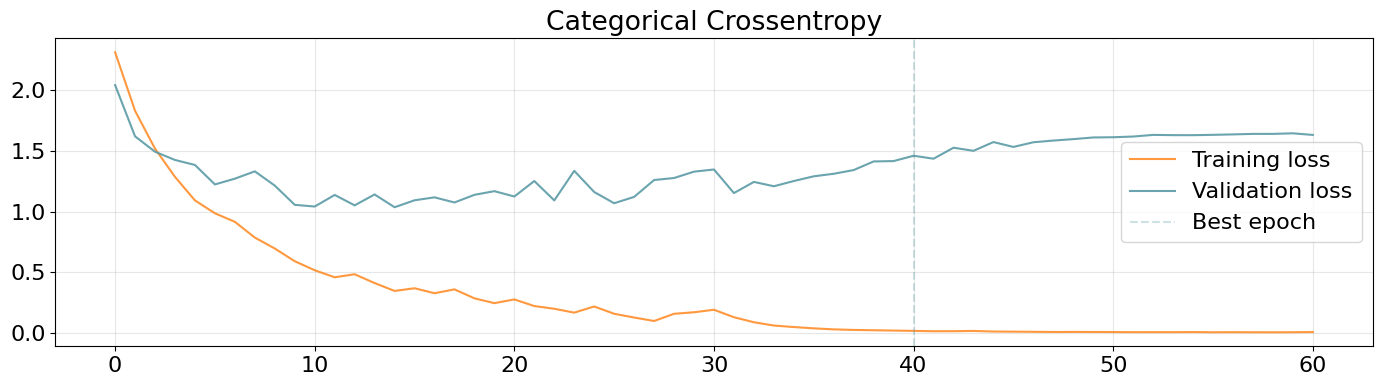

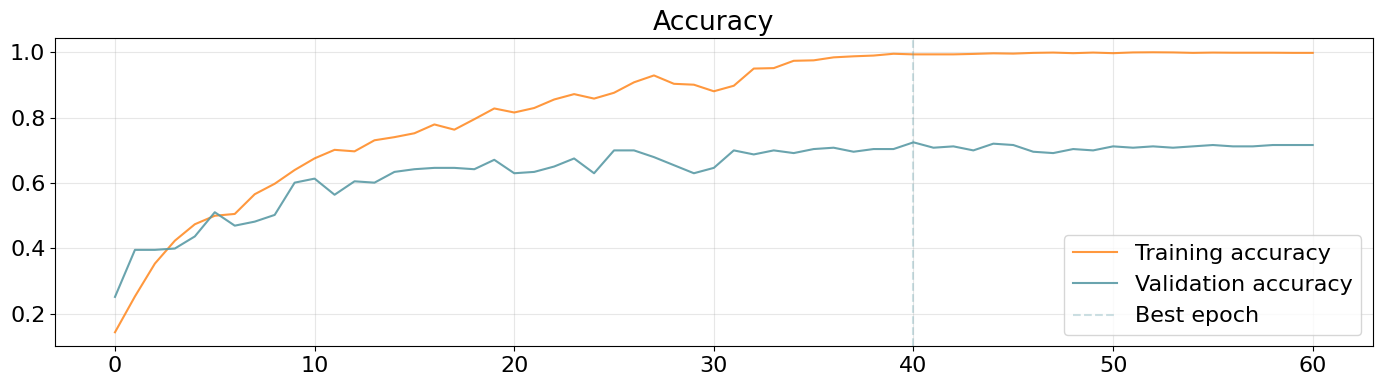

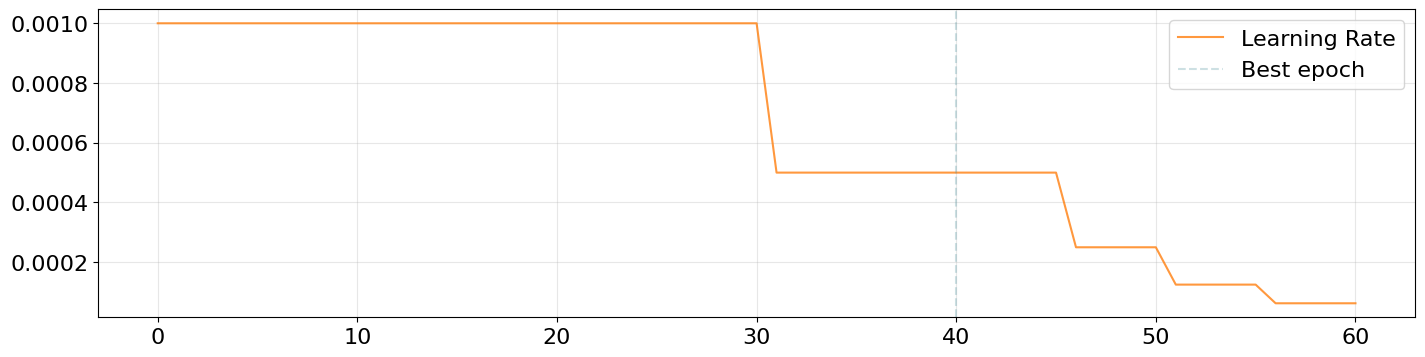

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()